# Supervised Machine Learning - Data Classification Demo

> This project aims to analyze and classify a real network traffic data set to detect malicious/benign traffic records. It compares the performance of various Machine Learning algorithms and tunes the best-performing model to maintain the highest accuracy and lowest False Negative metrics.

> The dataset used in this demo is [CTU-IoT-Malware-Capture-34-1](https://mcfp.felk.cvut.cz/publicDatasets/IoT-23-Dataset/IndividualScenarios/CTU-IoT-Malware-Capture-34-1/bro/), it is part of [Aposemat IoT-23 dataset](https://www.stratosphereips.org/datasets-iot23) (A labeled dataset with malicious and benign IoT network traffic).
>

# 1. Initialization

In [62]:
#importing required libraries and modules
import pandas as pd
import numpy as np
import seaborn as sns

#set display options
pd.set_option('display.max_columns', None)

## 2. Load Dataset

### Reading dataset file into DataFrame

In [63]:
#initialize required variables to read from the data file
data_file_location = "data\\raw\\"
data_file_name = "conn.log.labeled"

#column names are included in the file in a commented line, so we need to read the corresponding line separately and remove the first description word.
data_columns = pd.read_csv(data_file_location + data_file_name, sep='\t', skiprows=6, nrows=1, header=None).iloc[0][1:]

#read the actual dataset
data_df = pd.read_csv(data_file_location + data_file_name, sep='\t', comment="#", header=None)

#set column names
data_df.columns = data_columns

### Exploring dataset summary and statistics

In [64]:
#check dataset shape
data_df.shape

(23145, 21)

In [65]:
#check dataset head
data_df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents label detailed-label
0,1.545404e+09,CrDn63WjJEmrWGjqf,192.168.1.195,41040,185.244.25.235,80,tcp,-,3.139211,0,0,S0,-,-,0,S,3,180,0,0,- Benign -
1,1.545404e+09,CY9lJW3gh1Eje4usP6,192.168.1.195,41040,185.244.25.235,80,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,- Benign -
2,1.545404e+09,CcFXLynukEDnUlvgl,192.168.1.195,41040,185.244.25.235,80,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,- Benign -
3,1.545404e+09,CDrkrSobGYxHhYfth,192.168.1.195,41040,185.244.25.235,80,tcp,http,1.477656,149,128252,SF,-,-,2896,ShADadttcfF,94,5525,96,139044,- Benign -
4,1.545404e+09,CTWZQf2oJSvq6zmPAc,192.168.1.195,41042,185.244.25.235,80,tcp,-,3.147116,0,0,S0,-,-,0,S,3,180,0,0,- Benign -


In [66]:
#check dataset summary
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23145 entries, 0 to 23144
Data columns (total 21 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   ts                                       23145 non-null  float64
 1   uid                                      23145 non-null  object 
 2   id.orig_h                                23145 non-null  object 
 3   id.orig_p                                23145 non-null  int64  
 4   id.resp_h                                23145 non-null  object 
 5   id.resp_p                                23145 non-null  int64  
 6   proto                                    23145 non-null  object 
 7   service                                  23145 non-null  object 
 8   duration                                 23145 non-null  object 
 9   orig_bytes                               23145 non-null  object 
 10  resp_bytes                               23145

# 3. Data Cleaning

### Fixing combined column
The last columns in the dataset contains three separate values and needs to be unpacked into three corresponding columns. This is due to unmatched separators in the original data file.

In [67]:
#split the last combined column into three ones
tunnel_parents_column = data_df.iloc[:,-1].apply(lambda x: x.split()[0])
label_column = data_df.iloc[:,-1].apply(lambda x: x.split()[1])
detailed_label_column = data_df.iloc[:,-1].apply(lambda x: x.split()[2])

In [68]:
#drop the combined column
data_df.drop(["tunnel_parents   label   detailed-label"], axis=1, inplace=True)

In [69]:
#add new individual columns to the dataset
data_df["tunnel_parents"] = tunnel_parents_column
data_df["label"] = label_column
data_df["detailed_label"] = detailed_label_column

In [70]:
#check the dataset
data_df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed_label
0,1.545404e+09,CrDn63WjJEmrWGjqf,192.168.1.195,41040,185.244.25.235,80,tcp,-,3.139211,0,0,S0,-,-,0,S,3,180,0,0,-,Benign,-
1,1.545404e+09,CY9lJW3gh1Eje4usP6,192.168.1.195,41040,185.244.25.235,80,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,-,Benign,-
2,1.545404e+09,CcFXLynukEDnUlvgl,192.168.1.195,41040,185.244.25.235,80,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,-,Benign,-
3,1.545404e+09,CDrkrSobGYxHhYfth,192.168.1.195,41040,185.244.25.235,80,tcp,http,1.477656,149,128252,SF,-,-,2896,ShADadttcfF,94,5525,96,139044,-,Benign,-
4,1.545404e+09,CTWZQf2oJSvq6zmPAc,192.168.1.195,41042,185.244.25.235,80,tcp,-,3.147116,0,0,S0,-,-,0,S,3,180,0,0,-,Benign,-


### Drop irrelevant columns
Drop extra columns that don't contribute to the data analysis and predictions (ex. ids, columns with only unique values, columns with just one value, ...).

In [71]:
#check the number of unique values in each column
data_df.nunique().sort_values(ascending=False)

0
ts                23145
uid               23145
duration           4654
id.orig_p          4383
orig_ip_bytes       108
resp_ip_bytes        62
orig_pkts            53
id.resp_h            49
resp_bytes           44
orig_bytes           29
resp_pkts            28
history              26
id.resp_p            10
conn_state            6
service               5
detailed_label        4
missed_bytes          3
proto                 2
id.orig_h             2
label                 2
local_resp            1
local_orig            1
tunnel_parents        1
dtype: int64

In [72]:
#two columns have only unique values and three columns have only one value, so we should drop them.
data_df.drop(columns=["ts","uid","local_resp","local_orig","tunnel_parents"], inplace=True)

#the "detailed label" column provides more information about the "label" column itself, so it doesn't contribute to the data analysis.
data_df.drop(columns="detailed_label", inplace=True)

#check the dataset
data_df.head()

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,192.168.1.195,41040,185.244.25.235,80,tcp,-,3.139211,0,0,S0,0,S,3,180,0,0,Benign
1,192.168.1.195,41040,185.244.25.235,80,tcp,-,-,-,-,S0,0,S,1,60,0,0,Benign
2,192.168.1.195,41040,185.244.25.235,80,tcp,-,-,-,-,S0,0,S,1,60,0,0,Benign
3,192.168.1.195,41040,185.244.25.235,80,tcp,http,1.477656,149,128252,SF,2896,ShADadttcfF,94,5525,96,139044,Benign
4,192.168.1.195,41042,185.244.25.235,80,tcp,-,3.147116,0,0,S0,0,S,3,180,0,0,Benign


### Handle missing values
According to the dataset documentation, empty and unset values are represented as "-" and "(empty)". This is why info() method did't show any missing values.

In [12]:
#replace all occurrences of empty/unset cells with null values.
data_df.replace({'-':np.nan, "(empty)":np.nan}, inplace=True)

In [13]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23145 entries, 0 to 23144
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id.orig_h      23145 non-null  object
 1   id.orig_p      23145 non-null  int64 
 2   id.resp_h      23145 non-null  object
 3   id.resp_p      23145 non-null  int64 
 4   proto          23145 non-null  object
 5   service        1847 non-null   object
 6   duration       5321 non-null   object
 7   orig_bytes     5321 non-null   object
 8   resp_bytes     5321 non-null   object
 9   conn_state     23145 non-null  object
 10  missed_bytes   23145 non-null  int64 
 11  history        23145 non-null  object
 12  orig_pkts      23145 non-null  int64 
 13  orig_ip_bytes  23145 non-null  int64 
 14  resp_pkts      23145 non-null  int64 
 15  resp_ip_bytes  23145 non-null  int64 
 16  label          23145 non-null  object
dtypes: int64(7), object(10)
memory usage: 3.0+ MB


<Axes: xlabel='0'>

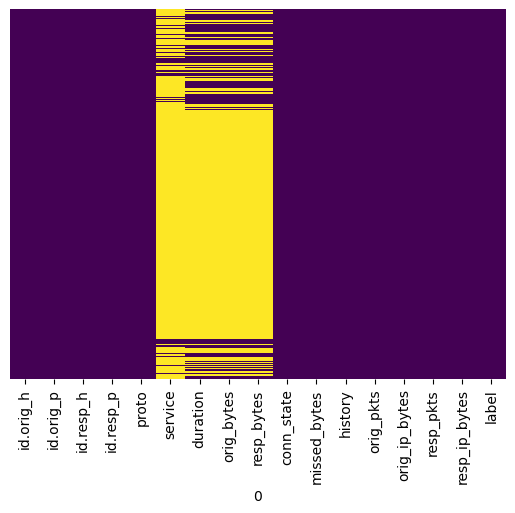

In [37]:
#check null values using heatmap
sns.heatmap(data=data_df.isnull(), yticklabels=False, cbar=False, cmap="viridis")